In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import enum
import pickle
from pathlib import Path
import time
import loglikelihood as llhood
import multiprocessing as mp
import pandas as pd # for reporting

# Kernel density estimation with Mixture of Gaussians

## Configuration

In [2]:
# Constants
CIFAR_100_DIR = Path('cifar-100-python')
MNIST_PICKLE = Path('mnist.pkl')
TRAIN_SIZE = 10000
VAL_SIZE = 10000
# Number of cores to use
NUM_PROCS = 3

## Loading Data

In [3]:
def get_data_from_pickle(path, encoding='bytes'):
    """Get img and label data  from Pickle file """

    with path.open('rb') as fo:
        
        data = pickle.load(fo, encoding='bytes')
    return data 

In [4]:
def load_cifar100(directory: Path, output_dtype: np.float = np.float32):
    """Get CIFAR 100 data. Extracts data from test, train files.
    :param 
    
    """
    test_data_file = directory/'test' 
    train_data_file = directory/'train' 
    meta_file = directory/'meta'
    
    # Validate Path
    if not directory.is_dir():
        raise ValueError(' CIFAR100 : Specified data dir is invalid! : %s' %(directory,)) 
    
    datasets = []
    for data_file in (train_data_file, test_data_file):
        
        if not data_file.is_file():
            raise ValueError(' CIFAR100 : Path %s doesn\'t point to a file' % str(data_file))

        # Load Data
        data = get_data_from_pickle(data_file)
        images, labels = data[b'data'], data[b'coarse_labels']

        # Normalize to [0,1] per image (num_imgs, pixel_data )
        # Per Image normalization
        #images = (images - images.min(axis = 1)[:, None])/images.ptp(axis = 1)[:, None]
        # Dataset level normalization
        images = images/255.
        images = images.astype(output_dtype)
        datasets.append((images, np.array(labels)))
    
    return datasets    

train_set, test_set = load_cifar100(CIFAR_100_DIR) 
print(train_set[0].shape, test_set[0].shape, )

(50000, 3072) (10000, 3072)


In [5]:

def load_mnist(path: Path, output_dtype : np.float = np.float32):
    """"Load MNIST Dataset"""
    # Contains train, valid, test sets
    datasets = get_data_from_pickle(path)
    
    # Discar validation set, since we construct that from the training set
    datasets = (list(datasets[0]), list(datasets[1]))
    
    # data : (imgs, labels), Normalize per image (num_imgs, pixel_data )
    # Change to dataset level normalization
    for data in datasets:
        img = (data[0] - data[0].min(axis=1)[:, None])/data[0].ptp(axis=1)[:, None]
        data[0] = img.astype(output_dtype)
    
    return datasets
    #print(train_set, len(data[0]))
    
train_set, test_set = load_mnist(MNIST_PICKLE)
print(train_set[0].shape, test_set[0].shape, )

(50000, 784) (10000, 784)


In [6]:
def shuffle_split(data):
    """Shuffle the dev data, generate training, validation and test sets."""
    dev_set, test_set = data
    imgs, labels = dev_set
    
    # Generate random indices and shuffle data
    random_i = np.arange(imgs.shape[0])
    np.random.shuffle(random_i)
    imgs, labels = imgs[random_i, :], labels[random_i]
    
    # Generate training and validation sets
    val_end = TRAIN_SIZE + VAL_SIZE
    train_set = imgs[:TRAIN_SIZE, :], labels[:TRAIN_SIZE]
    val_set = imgs[TRAIN_SIZE : val_end, :], labels[TRAIN_SIZE : val_end]
    
    return train_set, val_set, test_set

class DatasetType(enum.Enum):
    MNIST = 0
    CIFAR100 = 1
    
def load_data(dataset : DatasetType, output_dtype = np.float32):
    """Load the data based on the provided type."""
    if dataset == DatasetType.MNIST:
        data = load_mnist(MNIST_PICKLE, output_dtype)
    elif dataset == DatasetType.CIFAR100:
        data = load_cifar100(CIFAR_100_DIR, output_dtype) 
    else:
        raise ValueError('Invalid Dataset requested')
    return shuffle_split(data)


## Visualizing Data

The below section visualizes 400 images from each dataset

In [7]:
def visualize_dataset(imgs, img_channels=3, num_to_plot=400):
    """ Plot first 400 imgs, assumes axis = 0 corresponds to batch """
    imgs = imgs[:num_to_plot]
    
    # Get side of the img square and n
    img_hw = int((imgs.shape[1]/img_channels) ** 0.5)
    plt_num = int(num_to_plot ** 0.5)

    # Lets make a big img since we don't want to loop around so many imgs.
    # Swap channels and number of imgs so we can merge num_imgs with img dimensions
    imgs = imgs.reshape(-1, img_channels, img_hw* img_hw).transpose(1,0, 2)
    
    # Create Grid of imgs: Grid of size plt_hw * plt_hw and img of img_hw * imgs_hw
    # Final img is required to be img_height * num_imgs, ..,  
    imgs = imgs.reshape(img_channels, plt_num , plt_num, img_hw, img_hw).swapaxes(2, 3)
    imgs = imgs.reshape(img_channels, plt_num * img_hw, plt_num * img_hw).transpose(1, 2, 0)
    imgs = imgs.squeeze()
   
    # Plot Imgs
    cmap = None if img_channels > 1 else 'gray'
    plt.figure(figsize=(15,15))
    plt.imshow(imgs, interpolation='nearest', cmap=cmap)
    plt.show()



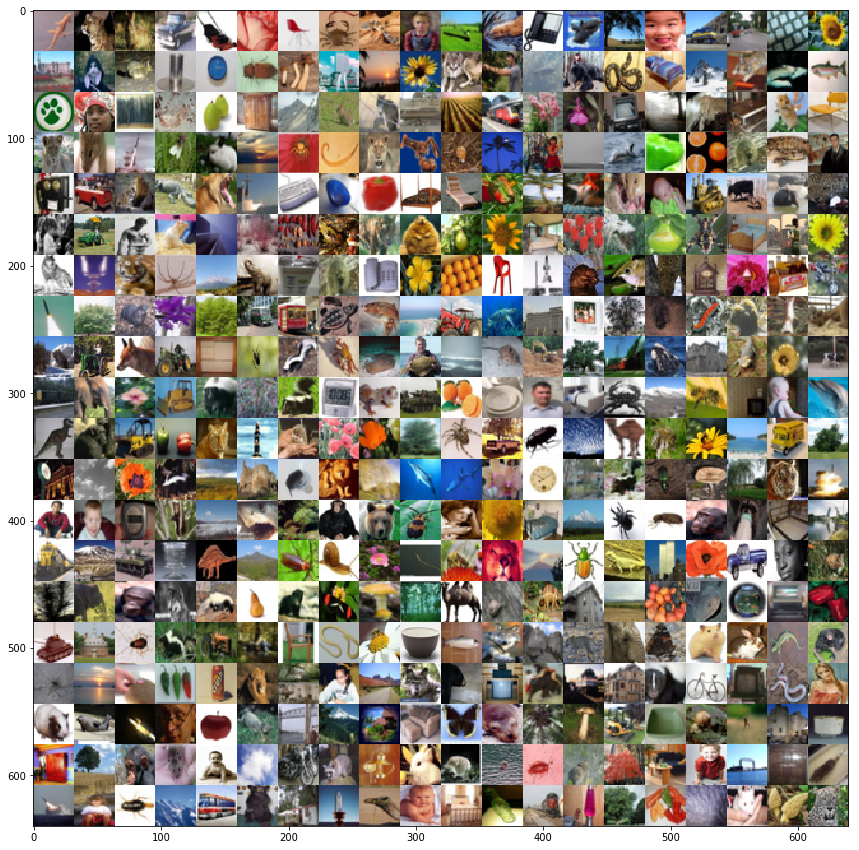

In [8]:
# Visualize CIFAR100
train_set, _, _ = load_data(DatasetType.CIFAR100)
visualize_dataset(train_set[0])   

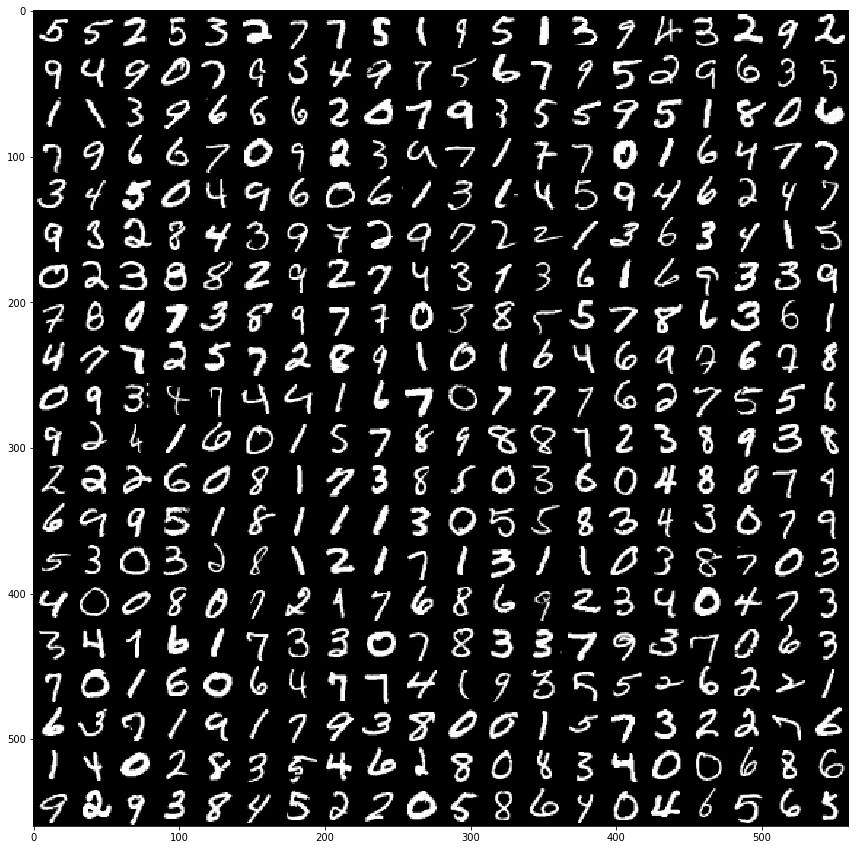

In [9]:
# Visualize MNIST
train_set, _, _ = load_data(DatasetType.MNIST)
visualize_dataset(train_set[0], 1)  

## About the Implementation
Since my final implementation uses multiprocessing, the code has been shifted to a separate file (loglikelihood.py) so that it can be invoked.  

I also have a batch version that can also be used with the multiprocessing. It isn't default because it can use large chunks of memory with CIFAR-100.

Also set NUM_PROCS in the beginning, based on how many cores of your system should be utlized (3-4 works well). Setting it to max_processors - 1, willleave some capacity of your system to do something else.

## The Model
$\log p(x)  = \log \sum_{i=1}^k p(z_i)p(x|z_i)$

$\log p(x)  = \log \sum_{i=1}^k \exp\{\sum^d_{j=1}[-\frac{ (x_j - \mu_{i,j}) ^ 2}{2\sigma^2} -\frac{1}{2}\log(2\pi \sigma^2)]  - \log k\}$ can be written as 

$\log p(x)  = - \log k + -\frac{d}{2}\log(2\pi \sigma^2) + \log \sum_{i=1}^k \exp\{\sum^d_{j=1}[-\frac{ (x_j - \mu_{i,j}) ^ 2}{2\sigma^2}]  \}$

$\log p(x)  = log\_prob\_z\_i + log\_normal\_b + log\_sum\_exp(\sum^d_{j=1}log\_normal\_a)$

$\text{Here } log\_normal\_a \text{ and } log\_normal\_b \text{ indicate different parts of the equation, used purely for explainability}$ 

In [10]:
llhood.log_likelihood??

Signature: llhood.log_likelihood(X_a, X_b, sigma)
Source:   
def log_likelihood(X_a, X_b, sigma):
    """Compute the mean log likelihood of X_b under X_a using a mixture of gaussians, one gaussian per feature
    :param X_a : np.ndarray : (samples, features)
    :param X_b : np.ndarray: (samples, features)
    :sigma : Standard deviation used for all the gaussians 
    
    """
    #start_time = time.time()

    # For effeciency Pre-compute fixed parts of the model
    # log_prob_z: -log k
    var = sigma ** 2
    log_prob_z = -np.log(X_a.shape[0])
    log_normal_b = -0.5 * np.log(2 * np.pi * var) * X_a.shape[1]
    log_prob_x = np.float64()
    
    for i in range(X_b.shape[0]):
        x_b = X_b[i]
        log_normal_a = -((x_b - X_a) ** 2)/(2 * var) 
        log_prob_x += log_sum_exp(log_normal_a.sum(axis=1)) + log_normal_b +  log_prob_z
    log_prob_x = log_prob_x/X_b.shape[0]
    
    #print("Total time: %.2f mins" % ((time.time() - start_time)/60)) 
    
    return log_prob_x
Fil

In [11]:
llhood.log_sum_exp??

Signature: llhood.log_sum_exp(X)
Source:   
def log_sum_exp(X):
    """ Compute log sum exp over X: axis 0. 
    Further prevent overflow/underflow using subtract max trick """
    max_x = np.max(X)
    X_ = X - max_x 
    return max_x  + np.log(np.sum(np.exp(X_)))
File:      ~/en/loglikelihood.py
Type:      function


In [12]:
def parallel_log_likelihood(X_a, X_b, sigma, llhood_func = llhood.log_likelihood, num_proc=2):
    """
    Compute the mean log likelihood by exploiting processor parallelism. Divides X_b along axis=0.
    The log likelihood of X_b under X_a using a mixture of gaussians, one gaussian per feature
    :param X_a : np.ndarray : (samples, features)
    :param X_b : np.ndarray: (samples, features)
    :sigma : Standard deviation used for all the gaussians 
    """
    start_time = time.time()
    chunk_size = X_b.shape[0]//num_proc
    X_b_chunks = np.array_split(X_b, num_proc)
    pool = mp.Pool(processes=num_proc)
    proc_results = [pool.apply_async(llhood_func,
                                     args=(X_a, X_b_chunk, sigma))
                    for X_b_chunk in X_b_chunks]
    # Wait for each worker to be done and re-normalize the data 
    result_chunks = [X_b_chunks[i].shape[0] *  r.get() for i, r in enumerate(proc_results)]
    pool.close()
    
    end_time = (time.time() - start_time)/60
    print("Total time: %.2f mins" % (end_time)) 
    
    return sum(result_chunks)/X_b.shape[0], end_time
    

## Test Run
Default run with a small subset of the validation code, meant to check the functionality and effeciency. 
By default np uses float64, but for our goal even float32 works, faster and more effecient. Based on these results I changed the default type 

NOTE: Please set NUM_PROCS in the beginning. Ideally a value of max_processors - 1 to leave some capacity of your system to do something else.

In [13]:
# Test with np deafult precision level
train_set, valid_set, test_set = load_data(DatasetType.CIFAR100, np.float64)
train_img, valid_img, test_img = train_set[0], valid_set[0], test_set[0]
parallel_log_likelihood(train_img, valid_img[:200], 0.5, num_proc= NUM_PROCS)[0]

Total time: 0.32 mins


-911.2788748084342

In [14]:
# Compare size of the objects at different precisions
the_size = (train_img.size * train_img.itemsize)/(1024. * 1024)
print(" With Float64 %.2f MB" % the_size)

train_img2 = train_img.astype(np.float32)
the_size = (train_img2.size * train_img2.itemsize)/(1024. * 1024)
print(" With Float32 %.2f MB" % the_size)

 With Float64 234.38 MB
 With Float32 117.19 MB


In [15]:
# Test with reduced precision 
train_img2 = train_img.astype(np.float32)
valid_img2 = valid_img.astype(np.float32)
parallel_log_likelihood(train_img2, valid_img2[:200], 0.5, num_proc=NUM_PROCS)[0]

Total time: 0.16 mins


-911.278882419984

As the log likelihood values indicate, the difference in precision only causes minute differences.

## Hyperparam sweep


In [16]:
def param_sweep(train_img, valid_img):
    """ Search """
    sigma_list = (0.05, 0.08, 0.1, 0.2, 0.5, 1., 1.5, 2.)
    results = {}
    for sigma in sigma_list:
        ll, _ = parallel_log_likelihood(train_img, valid_img, sigma, num_proc=NUM_PROCS)
        results[str(sigma)] = ll
    print(results)
    return pd.DataFrame({'sigma':list(results.keys()) , 'log-lhood' : list(results.values())})
    

### For MNIST

In [17]:
train_set, valid_set, test_set = load_data(DatasetType.MNIST)
train_img, valid_img, test_img = train_set[0], valid_set[0], test_set[0]
results_mnist = param_sweep(train_img, valid_img)
results_mnist.to_csv('results-mnist.csv')

Total time: 1.59 mins
Total time: 1.63 mins
Total time: 1.61 mins
Total time: 1.58 mins
Total time: 1.61 mins
Total time: 1.61 mins
Total time: 1.61 mins
Total time: 1.63 mins
{'0.05': -3167.8146846306818, '0.08': -619.3315497150941, '0.1': -121.12840570350876, '0.2': 232.99010623121356, '0.5': -233.93695682918639, '1.0': -740.9118219540633, '1.5': -1051.1379175312193, '2.0': -1272.9809994698626}


In [18]:
results_mnist

,sigma,log-lhood
0,0.05,-3167.814685
1,0.08,-619.331550
2,0.1,-121.128406
3,0.2,232.990106
4,0.5,-233.936957
5,1.0,-740.911822
6,1.5,-1051.137918
7,2.0,-1272.980999


The results highlight that max log likelihood is attained at $\sigma=0.2$. So we use that for the test set.

In [19]:
mnist_test_llhood, mnist_time = parallel_log_likelihood(train_img, test_img, 0.2, num_proc=NUM_PROCS)

Total time: 1.67 mins


### For CIFAR

In [20]:
train_set, valid_set, test_set = load_data(DatasetType.CIFAR100)
train_img, valid_img, test_img = train_set[0], valid_set[0], test_set[0]
results_cifar = param_sweep(train_img, valid_img)
results_cifar.to_csv('results-cifar.csv')

Total time: 7.32 mins
Total time: 7.31 mins
Total time: 7.36 mins
Total time: 7.25 mins
Total time: 7.27 mins
Total time: 7.32 mins
Total time: 7.29 mins
Total time: 7.38 mins
{'0.05': -13773.632553583193, '0.08': -2942.02947051605, '0.1': -794.7285447391466, '0.2': 852.9937097439466, '0.5': -904.2182437149253, '1.0': -2882.261552112721, '1.5': -4099.421169798485, '2.0': -4972.688670211924}


In [21]:
results_cifar

,sigma,log-lhood
0,0.05,-13773.632554
1,0.08,-2942.029471
2,0.1,-794.728545
3,0.2,852.993710
4,0.5,-904.218244
5,1.0,-2882.261552
6,1.5,-4099.421170
7,2.0,-4972.688670


The results highlight that max log likelihood is attained at $\sigma=0.2$. So we use that for the test set.

In [22]:
cifar_test_llhood, cifar_time = parallel_log_likelihood(train_img, test_img, 0.2, num_proc=NUM_PROCS)

Total time: 7.29 mins


## Tabulating Testset Results 

In [23]:
mnist_time_str = '%.2f' % (mnist_time)
cifar_time_str = '%.2f' % (cifar_time)
pd.DataFrame({'Dataset': ['MNIST', 'CIFAR100'], 'Log-Lhood': [mnist_test_llhood, cifar_test_llhood], 'Running Time' : [mnist_time_str, cifar_time_str]})

,Dataset,Log-Lhood,Running Time
0,MNIST,234.713737,1.67
1,CIFAR100,843.762429,7.29
